In [1]:
import os
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load pre-trained face and eye detectors
face_cascade = cv2.CascadeClassifier('C:/Users/ROHIT KHETO/Desktop/4th_year/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('C:/Users/ROHIT KHETO/Desktop/4th_year/haarcascade_eye.xml')

# Load the trained model
model = load_model('C:/Users/ROHIT KHETO/Desktop/4th_year/TrainedModel/Fold_0.h5')

print("Libraries imported and models loaded successfully!")

Libraries imported and models loaded successfully!


In [2]:
def draw_boundary(img, classifier, scaleFactor, minNeighbors, color, text):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = classifier.detectMultiScale(gray_img, scaleFactor, minNeighbors)
    coords = []
    for (x, y, w, h) in features:
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, text, (x, y - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 1, cv2.LINE_AA)
        coords = [x, y, w, h]
    return coords

def detect_and_extract_eyes(img, faceCascade, eyeCascade):
    color = {"blue": (255, 0, 0), "red": (0, 0, 255)}
    coords = draw_boundary(img, faceCascade, 1.1, 10, color['blue'], "Face")
    eyes_img = None
    
    if len(coords) == 4:
        roi_img = img[coords[1]:coords[1] + coords[3], coords[0]:coords[0] + coords[2]]
        gray_roi = cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY)
        eyes = eyeCascade.detectMultiScale(gray_roi, 1.1, 12)
        
        if len(eyes) >= 1:
            ex, ey, ew, eh = eyes[0]
            ex1, ey1, ew1, eh1 = eyes[-1]
            combined_x = min(ex, ex1)
            combined_y = min(ey, ey1)
            combined_w = max(ex + ew, ex1 + ew1) - combined_x
            combined_h = max(ey + eh, ey1 + eh1) - combined_y
            
            # Extracting the eye region
            eyes_img = roi_img[combined_y:combined_y + combined_h, combined_x:combined_x + combined_w]
            
            cv2.rectangle(roi_img, (combined_x, combined_y), 
                          (combined_x + combined_w, combined_y + combined_h), color['red'], 2)
            cv2.putText(roi_img, "Eyes", (combined_x, combined_y - 4), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, color['red'], 1, cv2.LINE_AA)
    
    return eyes_img

In [18]:
# Load the image from file
image_path = 'C:/Users/ROHIT KHETO/Desktop/4th_year/image4.jpg'
frame = cv2.imread(image_path)

if frame is None:
    print("Error: Could not load image.")
else:
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    
    # Initialize variables for visualization and drowsiness status
    preprocessed_img = None
    detected_face_img = frame.copy()
    control_points_img = frame.copy()
    drowsy_status = "Unknown"
    
    if len(faces) > 0:
        # Process the largest face
        x, y, w, h = max(faces, key=lambda f: f[2] * f[3])  # Largest face
        face_region = gray[y:y+h, x:x+w]
        
        # Detect eyes within the face region
        eyes = eye_cascade.detectMultiScale(face_region, scaleFactor=1.3, minNeighbors=5)
        if len(eyes) >= 2:
            # Calculate combined bounding box for both eyes
            min_x, max_x = min(eyes[0][0], eyes[1][0]), max(eyes[0][0] + eyes[0][2], eyes[1][0] + eyes[1][2])
            min_y, max_y = min(eyes[0][1], eyes[1][1]), max(eyes[0][1] + eyes[0][3], eyes[1][1] + eyes[1][3])
            
            # Adjust coordinates to the original frame scale
            eye_region_x1 = x + min_x
            eye_region_y1 = y + min_y
            eye_region_x2 = x + max_x
            eye_region_y2 = y + max_y
            
            eyes_region = gray[eye_region_y1:eye_region_y2, eye_region_x1:eye_region_x2]
            
            if eyes_region.size > 0:
                preprocessed_img = cv2.resize(eyes_region, (150, 60)) / 255.0
                input_img = np.expand_dims(preprocessed_img, axis=(0, -1))
                predicted_class = np.argmax(model.predict(input_img), axis=1)[0]
                label_map = {0: "Not Drowsy", 1: "Drowsy"}
                drowsy_status = label_map.get(predicted_class, 'Unknown')
                cv2.rectangle(control_points_img, (eye_region_x1, eye_region_y1), 
                              (eye_region_x2, eye_region_y2), (0, 255, 0), 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


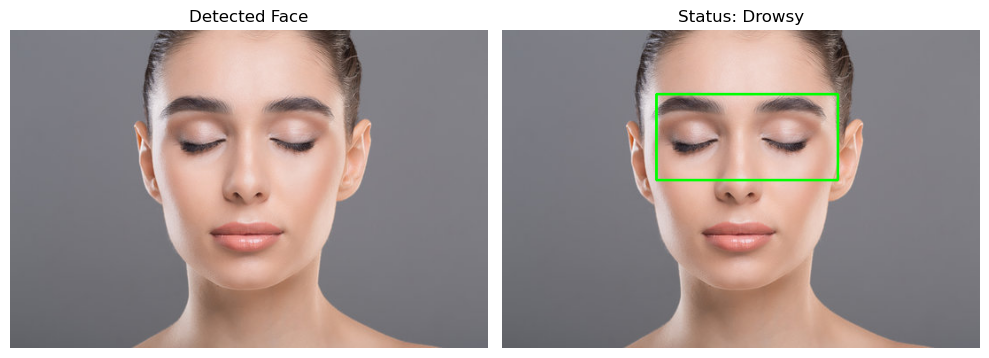

Face processed and drowsiness status determined.


In [20]:
# Visualize the detected face and drowsiness status
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

axes[0].imshow(cv2.cvtColor(detected_face_img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Detected Face")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(control_points_img, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"Status: {drowsy_status}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Face processed and drowsiness status determined.")